#### Get the credentials from [apps.twitter.com](https://apps.twitter.com)
Create an app <br>
Click on details tab of app <br>
Copy the sercet and api key to notebook<br>

In [22]:
import twitter
consumer_key = "idZoSeiMRZFUMlfp9aQDTbahW"
consumer_secret = "BB9EpYXAQivlFzsSeU7HYZ9kAh3vXgYbUKyGqTsyP7EhSAEXEb"
access_token = "1190195710416699395-xZL3GOULCvXOaQwHyhddMOaU9JhOkY"
access_token_secret = "axOzBlijTEogkS4TJKBnOAm5wUEzyI5albAB9svvmNYev"
authorization = twitter.OAuth(access_token, access_token_secret, consumer_key, consumer_secret)
t = twitter.Twitter(auth=authorization, retry=True)

In [23]:
import os
import json
data_folder = os.path.join("data", "twitter")
output_filename = os.path.join(data_folder, "python_tweets.json")

In [24]:
original_users = []
tweets = []
user_ids = {}

since_id=0
while len(set(user_ids))<400:
    search_results = t.search.tweets(q="python",max_id=since_id, count=100)
    for tweet in search_results['statuses']:
        if 'text' in tweet:
            original_users.append(tweet['user']['screen_name'])
            user_ids[tweet['user']['screen_name']] = tweet['user']['id']
            tweets.append(tweet['text'])
    temp = search_results['search_metadata']['next_results']
    since_id=temp[1:].split('&')[0].split('=')[1]
#     print(len(set(user_ids)),len(user_ids))

80 80
148 148
234 234
318 318
395 395
469 469


In [25]:
model_filename = os.path.join(data_folder, "model", "python_context.pkl")

In [26]:
from sklearn.base import TransformerMixin
from nltk import word_tokenize
from sklearn.feature_extraction import DictVectorizer

class NLTKBOW(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [{word: True for word in word_tokenize(document)}
                 for document in X]

In [27]:
import joblib
context_classifier = joblib.load(model_filename)

In [28]:
y_pred = context_classifier.predict(tweets)
y_pred[:10]

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [29]:
relevant_tweets = [tweets[i] for i in range(len(tweets)) if y_pred[i] == 1]
relevant_users = [original_users[i] for i in range(len(tweets)) if y_pred[i] == 1]
print(len(relevant_users))

93


In [31]:
relevent_user_filename = os.path.join(data_folder, "relevent_users.json")
with open(relevent_user_filename,'w') as outf:
    json.dump(relevant_users,outf)

In [32]:
user_id_filename = os.path.join(data_folder, "user_id.json")
with open(user_id_filename,'w') as outf:
    json.dump(user_ids,outf)

In [33]:
relevent_user_filename = os.path.join(data_folder, "relevent_users.json")
with open(relevent_user_filename,'r') as inf:
    relevant_users = json.load(inf)

In [35]:
user_id_filename = os.path.join(data_folder, "user_id.json")
with open(user_id_filename,'r') as inf:
    json.load(inf)

In [42]:
friends_filename = os.path.join(data_folder, "python_friends.json")

In [39]:
import time
import sys

def get_friends(t, user_id):
    friends = []
    cursor = -1
    while cursor != 0:  # If zero, that is the end:
        try:
            results = t.friends.ids(user_id=user_id, cursor=cursor, count=5000)
            friends.extend([friends for friends in results['ids']])
            cursor = results['next_cursor']
            if len(friends) >= 10000:
                break
            if cursor != 0:
                print("Collected {} friends so far, but there are more".format(len(friends)))
        except TypeError as e:
            if results is None:
                print("Reached API limit, waiting for 5 minutes")
                time.sleep(5*60) # 5 minute wait
            else:
                raise e
        except twitter.TwitterHTTPError as e:
            break
        finally:
            time.sleep(60)  # Wait 1 minute before continuing
    return friends


In [43]:
# friends = {}
for screen_name in relevant_users:
    print("Obtaining friends for user {0}, found friends of {1} users".format(screen_name,len(friends)))
    user_id = user_ids[screen_name]
    if not user_id in friends:
        friends[user_id] = get_friends(t, user_id)
        with open(friends_filename,'w') as outfile:
            json.dump(friends,outfile)

Obtaining friends for user beanisacarrot, found friends of 18 users
Obtaining friends for user Comatose_D, found friends of 18 users
Obtaining friends for user OhhYeez, found friends of 18 users
Obtaining friends for user ChriscoDevnet, found friends of 18 users
Obtaining friends for user Jeremy972i, found friends of 18 users
Obtaining friends for user helpwantedbot, found friends of 18 users
Obtaining friends for user dassenlanden, found friends of 18 users
Obtaining friends for user dassenlanden, found friends of 18 users
Obtaining friends for user Toradex, found friends of 18 users
Obtaining friends for user GamerGeekNews, found friends of 18 users
Obtaining friends for user dassenlanden, found friends of 18 users
Obtaining friends for user LlnuxBot, found friends of 18 users
Obtaining friends for user dassenlanden, found friends of 18 users
Obtaining friends for user DatafinSA, found friends of 18 users
Obtaining friends for user pythonbot_, found friends of 18 users
Obtaining frie

In [44]:
friends = {user_id:friends[user_id] for user_id in friends
             if len(friends[user_id]) > 0}

In [45]:
len(friends)

66

In [46]:
friends_filename = os.path.join(data_folder, "python_friends.json")

with open(friends_filename,'w') as outfile:
    json.dump(friends,outfile)

In [ ]:
friends_filename = os.path.join(data_folder, "python_friends.json")
with open(friends_filename) as inf:
    friends = json.load(inf)

In [47]:
from collections import defaultdict

In [48]:
def count_friends(friends):
    friend_count = defaultdict(int)
    for friend_list in friends.values():
        for friend in friend_list:
            friend_count[friend] += 1
    return friend_count

In [49]:
friend_count = count_friends(friends)

In [50]:
from operator import itemgetter
best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)

In [51]:
best_friends[:10]

[(44196397, 13),
 (555031989, 11),
 (20536157, 11),
 (931055758971752448, 10),
 (2736397896, 10),
 (3068484222, 10),
 (816653, 10),
 (13334762, 10),
 (74286565, 10),
 (808051518242979841, 10)]

In [52]:
len(friends)

66

In [53]:
friends_filename = os.path.join(data_folder, "python_friends.json")
while len(friends) < 150:
    # Get the best friend that isn't already in our list
    for user_id, count in best_friends:
        if user_id not in friends:
            break
    print("Getting friends of user {}".format(user_id))
    friends[user_id] = get_friends(t, user_id)
    print("Received {} friends".format(len(friends[user_id])))
    print("We now have the friends of {} users".format(len(friends)))
    # Update friend_count
    for friend in friends[user_id]:
        friend_count[friend] += 1
    # Update the best friends list
    with open(friends_filename, 'w') as outf:
        json.dump(friends, outf)
    best_friends = sorted(friend_count.items(), key=itemgetter(1), reverse=True)

Getting friends of user 44196397
Received 80 friends
We now have the friends of 67 users
Getting friends of user 555031989
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 68 users
Getting friends of user 20536157
Received 213 friends
We now have the friends of 69 users
Getting friends of user 816653
Received 1048 friends
We now have the friends of 70 users
Getting friends of user 13334762
Received 306 friends
We now have the friends of 71 users
Getting friends of user 11348282
Received 298 friends
We now have the friends of 72 users
Getting friends of user 931055758971752448
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 73 users
Getting friends of user 2736397896
Collected 5000 friends so far, but there are more
Received 10000 friends
We now have the friends of 74 users
Getting friends of user 808051518242979841
Collected 5000 friends so far, but there are more
Received 10000 frien

Getting friends of user 16228398
Received 1568 friends
We now have the friends of 149 users
Getting friends of user 19058681
Received 698 friends
We now have the friends of 150 users


In [54]:
import json
friends_filename = os.path.join(data_folder, "python_friends.json")
with open(friends_filename, 'w') as outf:
    json.dump(friends, outf)

In [57]:
import networkx as nx
G = nx.DiGraph()

main_users = friends.keys()
G.add_nodes_from(main_users)
count =0
for user_id in friends:
    for friend in friends[(user_id)]:
        if (friend) in main_users:
            count+=1
            G.add_edge(user_id, friend) 
G

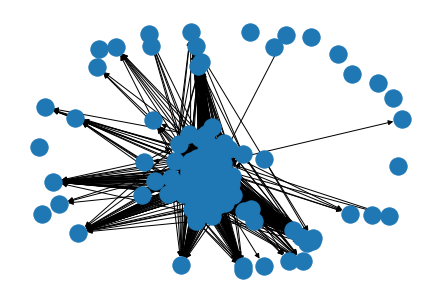

In [58]:
%matplotlib inline
nx.draw(G)

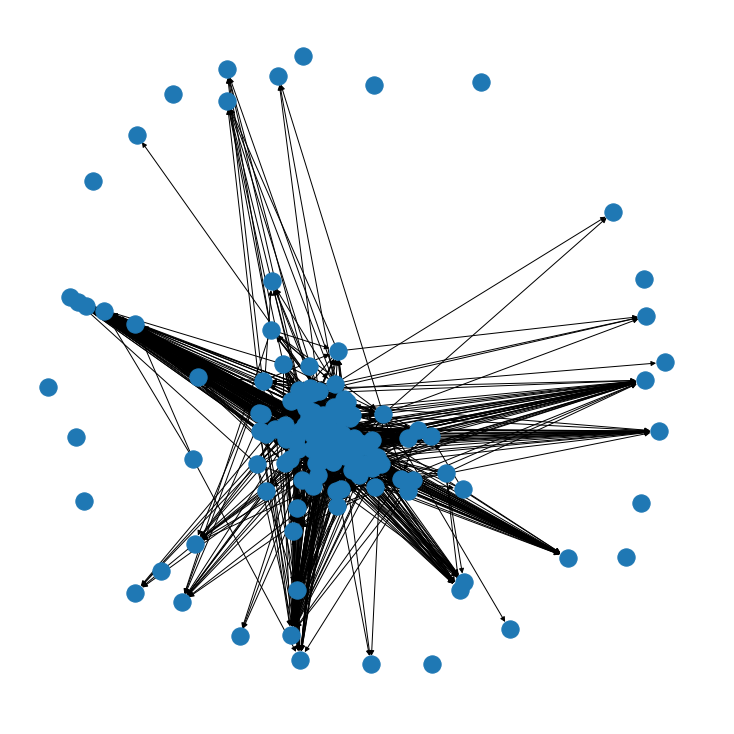

In [59]:
from matplotlib import pyplot as plt
plt.figure(3,figsize=(10, 10))
nx.draw(G)